In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from datetime import datetime
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from catboost import CatBoostRegressor


/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('max_columns',50)

In [277]:
train=pd.read_csv('/Users/shashank/Downloads/Societe/train.csv')
test=pd.read_csv('/Users/shashank/Downloads/Societe/test.csv')
sample=pd.read_csv('/Users/shashank/Downloads/Societe/sample_submission.csv')

In [278]:
# train=train[train['return']<0.5]

In [279]:
ids=test['portfolio_id']
Y=train['return']

In [280]:
## Convert to dollars

train.loc[train['currency']=='GBP','sold']=train.loc[train['currency']=='GBP','sold']*1.35
train.loc[train['currency']=='CHF','sold']=train.loc[train['currency']=='CHF','sold']*1.02
train.loc[train['currency']=='EUR','sold']=train.loc[train['currency']=='EUR','sold']*1.19
train.loc[train['currency']=='JPY','sold']=train.loc[train['currency']=='JPY','sold']*0.0089

test.loc[train['currency']=='GBP','sold']=test.loc[train['currency']=='GBP','sold']*1.35
test.loc[train['currency']=='CHF','sold']=test.loc[train['currency']=='CHF','sold']*1.02
test.loc[train['currency']=='EUR','sold']=test.loc[train['currency']=='EUR','sold']*1.19
test.loc[train['currency']=='JPY','sold']=test.loc[train['currency']=='JPY','sold']*0.0089

In [281]:
train.loc[train['currency']=='GBP','bought']=train.loc[train['currency']=='GBP','bought']*1.35
train.loc[train['currency']=='CHF','bought']=train.loc[train['currency']=='CHF','bought']*1.02
train.loc[train['currency']=='EUR','bought']=train.loc[train['currency']=='EUR','bought']*1.19
train.loc[train['currency']=='JPY','bought']=train.loc[train['currency']=='JPY','bought']*0.0089

test.loc[train['currency']=='GBP','bought']=test.loc[train['currency']=='GBP','bought']*1.35
test.loc[train['currency']=='CHF','bought']=test.loc[train['currency']=='CHF','bought']*1.02
test.loc[train['currency']=='EUR','bought']=test.loc[train['currency']=='EUR','bought']*1.19
test.loc[train['currency']=='JPY','bought']=test.loc[train['currency']=='JPY','bought']*0.0089

In [282]:
train['libor_rate'].mean()

0.9980662280320226

In [283]:
train['libor_rate'].median()

0.5319833333333329

In [284]:
## Fill
train['libor_rate']=train['libor_rate'].fillna(train['libor_rate'].median())
train['status']=train['status'].fillna(False)
test['libor_rate']=test['libor_rate'].fillna(train['libor_rate'].median())
test['status']=test['status'].fillna(False)

In [285]:
train['sold']=train['sold'].fillna(train['sold'].median())
train['bought']=train['bought'].fillna(train['bought'].median())
test['sold']=test['sold'].fillna(train['sold'].median())
test['bought']=test['bought'].fillna(train['bought'].median())

In [286]:
## Extract the time features
train['start']=train['start_date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())
train['create']=train['creation_date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())
train['end']=train['sell_date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())

test['start']=test['start_date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())
test['create']=test['creation_date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())
test['end']=test['sell_date'].apply(lambda x: datetime.strptime(str(x),'%Y%m%d').date())



In [287]:
train.head()

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return,start,create,end
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,False,0.02496,2004-07-20,2004-07-20,2004-08-12
1,PF00001003,DSK00001002,OFF00001001,A,20040709,238505850.0,N,0.02074,GBP,5.269617,2.376114e+08,20040723,NaN,20040812,C,NaN,False,0.05496,2004-07-09,2004-07-23,2004-08-12
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,False,0.02496,2004-07-23,2004-07-23,2004-08-17
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,False,0.02496,2004-06-09,2004-07-23,2004-07-13
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,False,0.02496,2004-06-09,2004-07-23,2004-07-13


In [290]:
## between end and create
def f(row):
    return (row[-1]-row[-2]).days
    
train['duration']=train.apply(f,axis=1)
test['duration']=test.apply(f,axis=1)

In [291]:
train['duration']=train['duration'].apply(lambda x:0 if x<0 else x)
test['duration']=test['duration'].apply(lambda x:0 if x<0 else x)

In [292]:
# def f2(row):
#     return (row['end']-row['start']).days
    
# train['duration2']=train.apply(f2,axis=1)
# test['duration2']=test.apply(f2,axis=1)

In [293]:
train['hedge_value'].fillna(False, inplace=True)
test['hedge_value'].fillna(False, inplace=True)

In [294]:
train['indicator_code'].fillna(False, inplace=True)
test['indicator_code'].fillna(False, inplace=True)

In [295]:
train['m1']=train['start'].apply(lambda x:x.month)
train['m2']=train['create'].apply(lambda x:x.month)
train['m3']=train['end'].apply(lambda x:x.month)

test['m1']=test['start'].apply(lambda x:x.month)
test['m2']=test['create'].apply(lambda x:x.month)
test['m3']=test['end'].apply(lambda x:x.month)

In [296]:
train['d1']=train['start'].apply(lambda x:x.day)
train['d2']=train['create'].apply(lambda x:x.day)
train['d3']=train['end'].apply(lambda x:x.day)

test['d1']=test['start'].apply(lambda x:x.day)
test['d2']=test['create'].apply(lambda x:x.day)
test['d3']=test['end'].apply(lambda x:x.day)

In [297]:
train['y1']=train['start'].apply(lambda x:x.year)
train['y2']=train['create'].apply(lambda x:x.year)
train['y3']=train['end'].apply(lambda x:x.year)

test['y1']=test['start'].apply(lambda x:x.year)
test['y2']=test['create'].apply(lambda x:x.year)
test['y3']=test['end'].apply(lambda x:x.year)

In [298]:
train['w1']=train['start'].apply(lambda x:x.weekday())
train['w2']=train['create'].apply(lambda x:x.weekday())
train['w3']=train['end'].apply(lambda x:x.weekday())

test['w1']=test['start'].apply(lambda x:x.weekday())
test['w2']=test['create'].apply(lambda x:x.weekday())
test['w3']=test['end'].apply(lambda x:x.weekday())

In [1]:
# sc=StandardScaler()
# train['bought']=sc.fit_transform(train['bought'].reshape(-1, 1))
# sc=StandardScaler()
# train['sold']=sc.fit_transform(train['sold'].reshape(-1, 1))

# sc=StandardScaler()
# test['bought']=sc.fit_transform(test['bought'].reshape(-1, 1))
# sc=StandardScaler()
# test['sold']=sc.fit_transform(test['sold'].reshape(-1, 1))

In [489]:
trainX=train[['office_id','pf_category','country_code','euribor_rate','libor_rate',
             'type','duration','m2','m3','d1','d2','d3','y2','y3']]
testX=test[['office_id','pf_category','country_code','euribor_rate','libor_rate',
             'type','duration','m2','m3','d1','d2','d3','y2','y3',]]

In [488]:
trainX.head()

,office_id,pf_category,country_code,euribor_rate,libor_rate,type,duration,m2,m3,d1,d2,d3,y2,y3
0,OFF00001002,B,T,0.02074,2.332216,B,23,7,8,20,20,12,2004,2004
1,OFF00001001,A,N,0.02074,5.269617,C,20,7,8,9,23,12,2004,2004
2,OFF00001001,A,T,0.02074,2.332216,A,25,7,8,23,23,17,2004,2004
3,OFF00001001,A,T,0.02074,2.332216,A,-10,7,7,9,23,13,2004,2004
4,OFF00001002,B,T,0.02074,2.332216,B,-10,7,7,9,23,13,2004,2004


In [301]:
# trainX['ordinal1']=train['start'].apply(lambda x:x.toordinal())
# testX['ordinal1']=test['start'].apply(lambda x:x.toordinal())

In [455]:
# train['return'][1665]=0.78

In [437]:
# trainX=train[['office_id','pf_category','country_code','euribor_rate','libor_rate',
#              'type','status','duration','m1','m2','m3','d2','d3','y1','y2','y3']]
# testX=test[['office_id','pf_category','country_code','euribor_rate','libor_rate',
#              'type','status','duration','m1','m2','m3','d2','d3','y1','y2','y3']]

In [490]:
def encoder(df,cols):
    le=LabelEncoder()
    for i in cols:
        le.fit(df[i])
        df[i]=le.transform(df[i])

In [491]:
encoder(trainX,['office_id','pf_category','country_code','type',])
encoder(testX,['office_id','pf_category','country_code','type',])


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [492]:
# trainX['libor_rate']=np.log(trainX['libor_rate']+1)
# testX['libor_rate']=np.log(testX['libor_rate']+1)

In [493]:
X=trainX.iloc[:,:].values
y=Y.values

In [494]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [495]:
def run(X,y,test,params):
    dtrain=xgb.DMatrix(X,label=y)
    dtest=xgb.DMatrix(test)
    bst=xgb.train(params,dtrain,1000)
    preds=bst.predict(dtest)
    return bst,preds

params={
    'objective':'reg:linear',
    'eta':0.3,
    'subsample':1,
    'max_depth':7,
#     'colsample_bytree':0.9
#     'min_child_weight':2
    
    
    
}

In [496]:
# bst,preds=run(X_train,y_train,X_test,params)
# r2_score(y_test,preds)

In [497]:
# rf=RandomForestRegressor()
# score=cross_val_score(rf,X,y,cv=KFold(n_splits=10),scoring='r2')
# score.mean()

In [498]:
# rf=RandomForestRegressor()
# score=cross_val_score(rf,X,y,cv=KFold(n_splits=10),scoring='r2')
# score.mean()

In [499]:
# rf=RandomForestRegressor(n_estimators=350)
# rf.fit(X,y)
# preds=rf.predict(testX.values)

In [500]:
bst,preds=run(X,y,testX.iloc[:,:].values,params)

In [56]:
subs=pd.DataFrame({
    'portfolio_id':ids,
    'return':preds
},columns=['portfolio_id','return'])

In [57]:
subs.to_csv('/Users/shashank/Downloads/Societe/last1.csv',index=False)

In [2360]:
#45---highest
#121---highest
#122--highest
#128--highest
#130--highest--0.99347

##END NOTES
##PLAY WITH PARAMETERS
### And please come up with a way please






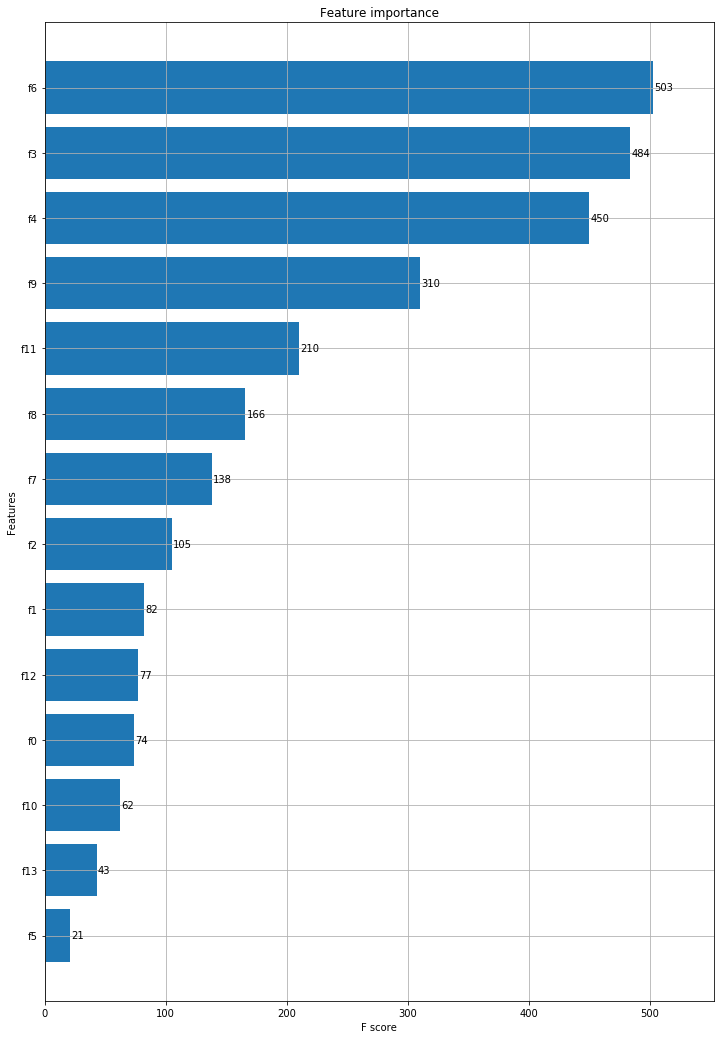

In [2253]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, height=0.8, ax=ax)
plt.show()

In [1928]:
## best is xgb with initial params and months,years,days,without sold and bought and status --56
## best is xgb with initial params and months,years,days,without sold and bought and status upper one wiht max depth-7
## best is xgb with initial params and months,years,days,without sold and bought and status upper one wiht max depth
## without m1-0.99024 --file 83 with only 'm2','m3','d1','d2','d3','y2','y3' --0.991 --highest ## remove hedge for highest


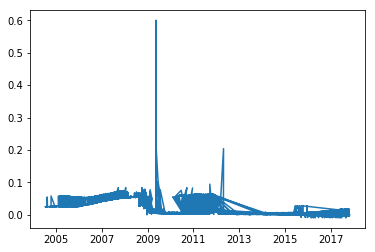

In [227]:
plt.plot(train['end'],train['return'])

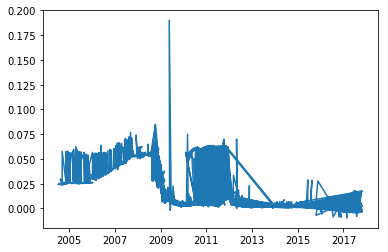

In [228]:
plt.plot(test['end'],preds)

In [ ]:
3744     True
4043     True
4407     True

In [284]:
preds[3744]=0.05

In [274]:
preds[3744]

0.027168691

In [2388]:
test[test['end']==2012-04-27]

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,start,create,end,duration,duration2,m1,m2,m3,d1,d2,d3,y1,y2,y3,w1,w2,w3


In [2400]:
np.argsort(preds)

array([4141, 4652, 4275, ...,  303,  428,  767])

In [2406]:
np.sort(preds)[::-1]

array([ 0.19      ,  0.08149463,  0.07664755, ..., -0.00899094,
       -0.00904292, -0.00927413], dtype=float32)

In [2413]:
np.where(preds==0.08149463)

(array([428]),)

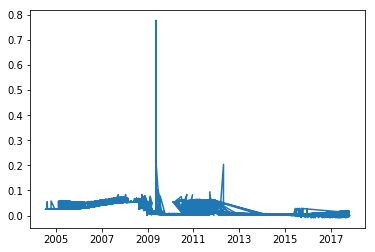

In [192]:
plt.plot(train['end'],train['return'])


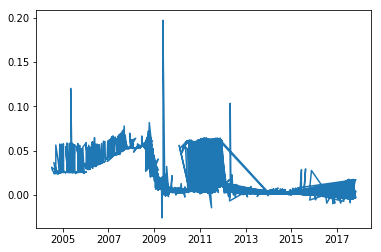

In [193]:
plt.plot(test['end'],preds)


In [2375]:
preds.argmax()

767

In [2376]:
preds[767]

0.18000001

In [225]:
sub=pd.read_csv('/Users/shashank/Downloads/Societe/subs130fresh.csv')

In [227]:
f=0.5*sub['return']+0.5*preds

In [228]:
f

0       0.024983
1       0.020102
2       0.025580
3       0.024770
4       0.024044
5       0.024844
6       0.025050
7       0.024530
8       0.025778
9       0.057390
10      0.025367
11      0.025353
12      0.024878
13      0.025092
14      0.025079
15      0.025038
16      0.024825
17      0.056893
18      0.025150
19      0.025221
20      0.025214
21      0.024658
22      0.027958
23      0.025933
24      0.025991
25      0.057026
26      0.025991
27      0.026017
28      0.024843
29      0.025960
          ...   
4771   -0.002681
4772    0.006201
4773    0.013128
4774    0.005000
4775   -0.002476
4776   -0.003253
4777   -0.002713
4778    0.007969
4779    0.007969
4780    0.007969
4781    0.007969
4782   -0.002521
4783    0.008311
4784    0.008530
4785   -0.002063
4786   -0.002825
4787   -0.003881
4788    0.011517
4789    0.005903
4790    0.000628
4791    0.006892
4792    0.003110
4793   -0.000296
4794    0.005471
4795   -0.001678
4796    0.005482
4797    0.005482
4798    0.0065